# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01   48% |███████████████▌                | 7.1MB 26.7MB/s eta 0:00:01    58% |██████████████████▊             | 8.5MB 27.4MB/s eta 0:00:01    70% |██████████████████████▋         | 10.3MB 28.5MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

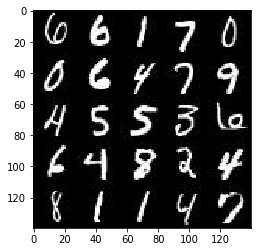

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

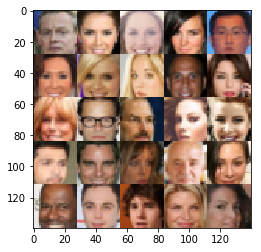

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    def conv_layer(tensor_in, filters, strides, use_batch_norm=True):
        tensor_out = tf.layers.conv2d(tensor_in, filters, 5, strides, padding="same",
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        if(use_batch_norm):
            tensor_out = tf.layers.batch_normalization(tensor_out, True)

        tensor_out = tf.maximum(alpha * tensor_out, tensor_out)
        
        return tensor_out
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # stack convolutional layers
        x1 = conv_layer(images, 32, 2, False)
        x2 = conv_layer(x1, 64, 1)
        x3 = conv_layer(x2, 128, 2)
        x4 = conv_layer(x3, 256, 1)
        x5 = conv_layer(x4, 512, 2)
        
        # flatten
        flat = tf.reshape(x5, (-1, 4 * 4 * 512))
        
        # compute output
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    def conv_transpose_layer(tensor_in, filters, strides, is_train, use_batch_norm_and_relu=True):
        tensor_out = tf.layers.conv2d_transpose(tensor_in, filters, 5, strides, padding="same",
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        if(use_batch_norm_and_relu):
            tensor_out = tf.layers.batch_normalization(tensor_out, training=is_train)
            tensor_out = tf.maximum(alpha * tensor_out, tensor_out)
        
        return tensor_out
        
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1) # 7 x 7 x 512
    
        # stack convolutional layer
        x2 = conv_transpose_layer(x1, 512, 1, is_train) # 7 x 7 x 512
        x3 = conv_transpose_layer(x2, 256, 2, is_train) # 14 x 14 x 256
        x4 = conv_transpose_layer(x3, 128, 1, is_train) # 14 x 14 x 128
        x5 = conv_transpose_layer(x4, 64, 2, is_train) # 28 x 28 x 64   
        logits = conv_transpose_layer(x5, out_channel_dim, 1, is_train, False)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logit_real = discriminator(input_real)
    d_model_fake, d_logit_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(
        data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    
    step_cnt = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step_cnt += 1
                
                # create random noise
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                
                # run optimizer
                sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                 input_z: batch_z,
                                                 input_lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                 input_z: batch_z,
                                                 input_lr: learning_rate})
                
                # print loss every 10 batches
                if(step_cnt % 10 == 0):
                    train_loss_d, train_loss_g = sess.run(
                        [d_loss, g_loss], feed_dict={input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show generated images every 100 batches
                if(step_cnt % 100 == 0):
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.3270... Generator Loss: 0.8109
Epoch 0/2... Discriminator Loss: 1.3874... Generator Loss: 0.5349
Epoch 0/2... Discriminator Loss: 1.0287... Generator Loss: 0.8582
Epoch 0/2... Discriminator Loss: 1.2461... Generator Loss: 0.6469
Epoch 0/2... Discriminator Loss: 1.3232... Generator Loss: 0.6729
Epoch 0/2... Discriminator Loss: 1.4657... Generator Loss: 0.6511
Epoch 0/2... Discriminator Loss: 1.2356... Generator Loss: 0.8541
Epoch 0/2... Discriminator Loss: 1.3842... Generator Loss: 0.7377
Epoch 0/2... Discriminator Loss: 1.3355... Generator Loss: 0.8062
Epoch 0/2... Discriminator Loss: 1.3445... Generator Loss: 0.7919


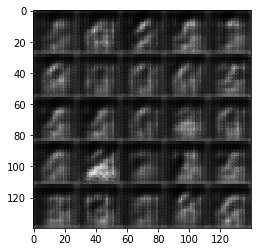

Epoch 0/2... Discriminator Loss: 1.4220... Generator Loss: 0.6071
Epoch 0/2... Discriminator Loss: 1.4312... Generator Loss: 0.6308
Epoch 0/2... Discriminator Loss: 1.4192... Generator Loss: 0.7550
Epoch 0/2... Discriminator Loss: 1.3675... Generator Loss: 0.8102
Epoch 0/2... Discriminator Loss: 1.3448... Generator Loss: 0.7469
Epoch 0/2... Discriminator Loss: 1.3428... Generator Loss: 0.8020
Epoch 0/2... Discriminator Loss: 1.3890... Generator Loss: 0.7698
Epoch 0/2... Discriminator Loss: 1.3779... Generator Loss: 0.7650
Epoch 0/2... Discriminator Loss: 1.3330... Generator Loss: 0.8163
Epoch 0/2... Discriminator Loss: 1.3795... Generator Loss: 0.7263


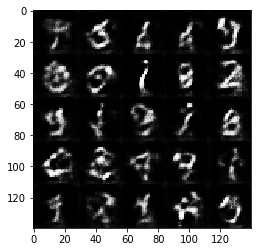

Epoch 0/2... Discriminator Loss: 1.3639... Generator Loss: 0.7679
Epoch 0/2... Discriminator Loss: 1.3995... Generator Loss: 0.7000
Epoch 0/2... Discriminator Loss: 1.3884... Generator Loss: 0.7536
Epoch 0/2... Discriminator Loss: 1.3644... Generator Loss: 0.7795
Epoch 0/2... Discriminator Loss: 1.4290... Generator Loss: 0.6154
Epoch 0/2... Discriminator Loss: 1.3943... Generator Loss: 0.7560
Epoch 0/2... Discriminator Loss: 1.3886... Generator Loss: 0.7359
Epoch 0/2... Discriminator Loss: 1.3840... Generator Loss: 0.7913
Epoch 0/2... Discriminator Loss: 1.4047... Generator Loss: 0.9173
Epoch 0/2... Discriminator Loss: 1.3733... Generator Loss: 0.7482


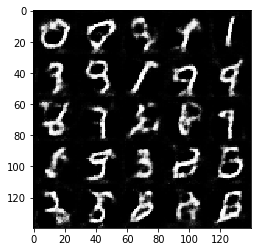

Epoch 0/2... Discriminator Loss: 1.3701... Generator Loss: 0.7534
Epoch 0/2... Discriminator Loss: 1.4252... Generator Loss: 0.6065
Epoch 0/2... Discriminator Loss: 1.3933... Generator Loss: 0.8019
Epoch 0/2... Discriminator Loss: 1.3749... Generator Loss: 0.7591
Epoch 0/2... Discriminator Loss: 1.3724... Generator Loss: 0.7375
Epoch 0/2... Discriminator Loss: 1.3893... Generator Loss: 0.7708
Epoch 0/2... Discriminator Loss: 1.3620... Generator Loss: 0.8029
Epoch 0/2... Discriminator Loss: 1.3660... Generator Loss: 0.7780
Epoch 0/2... Discriminator Loss: 1.3760... Generator Loss: 0.7345
Epoch 0/2... Discriminator Loss: 1.3577... Generator Loss: 0.8071


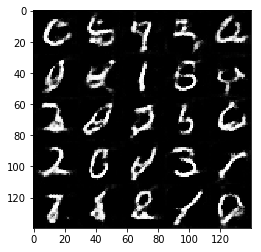

Epoch 0/2... Discriminator Loss: 1.3690... Generator Loss: 0.8113
Epoch 0/2... Discriminator Loss: 1.4083... Generator Loss: 0.7331
Epoch 0/2... Discriminator Loss: 1.3899... Generator Loss: 0.7849
Epoch 0/2... Discriminator Loss: 1.4048... Generator Loss: 0.7293
Epoch 0/2... Discriminator Loss: 1.3772... Generator Loss: 0.7792
Epoch 0/2... Discriminator Loss: 1.3661... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7724


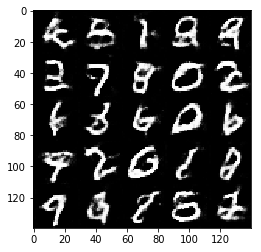

Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.8320
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.7263


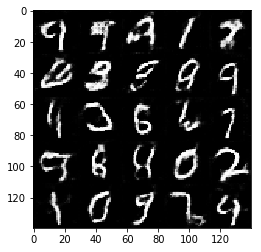

Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.7091


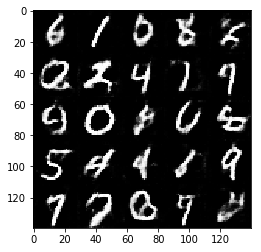

Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.8282
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7379


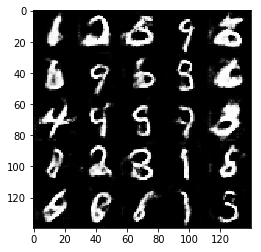

Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.6731


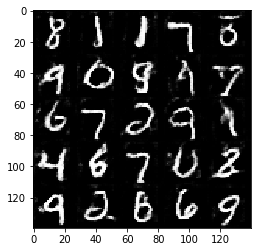

Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.7030


In [45]:
batch_size = 128
z_dim = 128
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.0607... Generator Loss: 1.1886
Epoch 0/1... Discriminator Loss: 1.1679... Generator Loss: 1.0817
Epoch 0/1... Discriminator Loss: 1.0796... Generator Loss: 1.2589
Epoch 0/1... Discriminator Loss: 1.3891... Generator Loss: 0.8851
Epoch 0/1... Discriminator Loss: 1.4667... Generator Loss: 0.6704
Epoch 0/1... Discriminator Loss: 1.0021... Generator Loss: 1.1853
Epoch 0/1... Discriminator Loss: 1.1062... Generator Loss: 1.1072
Epoch 0/1... Discriminator Loss: 1.0541... Generator Loss: 1.0152
Epoch 0/1... Discriminator Loss: 1.3243... Generator Loss: 0.9596
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 1.0011


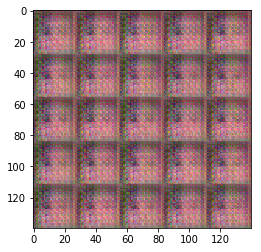

Epoch 0/1... Discriminator Loss: 1.6132... Generator Loss: 2.6536
Epoch 0/1... Discriminator Loss: 1.1567... Generator Loss: 0.8932
Epoch 0/1... Discriminator Loss: 1.4934... Generator Loss: 0.8856
Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.8034
Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 0.9183
Epoch 0/1... Discriminator Loss: 1.1691... Generator Loss: 0.8420
Epoch 0/1... Discriminator Loss: 1.3443... Generator Loss: 0.7382
Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.6499
Epoch 0/1... Discriminator Loss: 1.2847... Generator Loss: 0.8318
Epoch 0/1... Discriminator Loss: 1.3142... Generator Loss: 0.7774


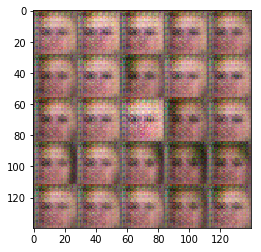

Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.8231
Epoch 0/1... Discriminator Loss: 1.4303... Generator Loss: 0.7160
Epoch 0/1... Discriminator Loss: 1.4274... Generator Loss: 0.7628
Epoch 0/1... Discriminator Loss: 1.4163... Generator Loss: 0.7326
Epoch 0/1... Discriminator Loss: 1.2903... Generator Loss: 0.7854
Epoch 0/1... Discriminator Loss: 1.3800... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.3205... Generator Loss: 0.7582
Epoch 0/1... Discriminator Loss: 1.3746... Generator Loss: 0.7845
Epoch 0/1... Discriminator Loss: 1.3471... Generator Loss: 0.8800
Epoch 0/1... Discriminator Loss: 1.5073... Generator Loss: 0.7085


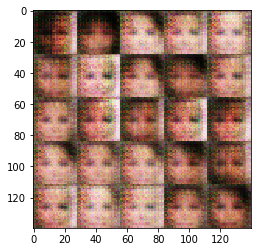

Epoch 0/1... Discriminator Loss: 1.3785... Generator Loss: 0.7216
Epoch 0/1... Discriminator Loss: 1.4257... Generator Loss: 0.8835
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 0.8123
Epoch 0/1... Discriminator Loss: 1.3381... Generator Loss: 0.8676
Epoch 0/1... Discriminator Loss: 1.3561... Generator Loss: 0.7460
Epoch 0/1... Discriminator Loss: 1.4416... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.8122
Epoch 0/1... Discriminator Loss: 1.3472... Generator Loss: 0.8028
Epoch 0/1... Discriminator Loss: 1.3375... Generator Loss: 0.8079
Epoch 0/1... Discriminator Loss: 1.3569... Generator Loss: 0.8487


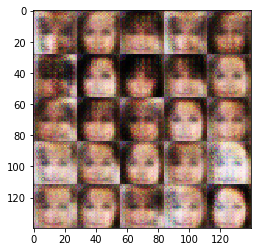

Epoch 0/1... Discriminator Loss: 1.3709... Generator Loss: 0.7852
Epoch 0/1... Discriminator Loss: 1.3824... Generator Loss: 0.7589
Epoch 0/1... Discriminator Loss: 1.3543... Generator Loss: 0.8731
Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 0.7645
Epoch 0/1... Discriminator Loss: 1.3587... Generator Loss: 0.8082
Epoch 0/1... Discriminator Loss: 1.3731... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 1.3820... Generator Loss: 0.8053
Epoch 0/1... Discriminator Loss: 1.3769... Generator Loss: 0.7979
Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.7933
Epoch 0/1... Discriminator Loss: 1.4232... Generator Loss: 0.6857


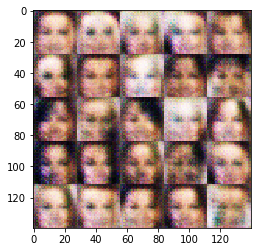

Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.8167
Epoch 0/1... Discriminator Loss: 1.3370... Generator Loss: 0.8253
Epoch 0/1... Discriminator Loss: 1.3866... Generator Loss: 0.7493
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.8453
Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.3856... Generator Loss: 0.7943
Epoch 0/1... Discriminator Loss: 1.3751... Generator Loss: 0.8495
Epoch 0/1... Discriminator Loss: 1.3434... Generator Loss: 0.7828
Epoch 0/1... Discriminator Loss: 1.3467... Generator Loss: 0.8073
Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.8149


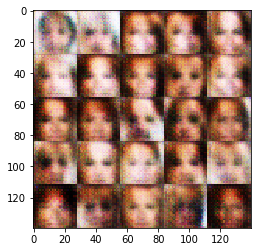

Epoch 0/1... Discriminator Loss: 1.3690... Generator Loss: 0.7667
Epoch 0/1... Discriminator Loss: 1.3997... Generator Loss: 0.7976
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.7785
Epoch 0/1... Discriminator Loss: 1.3551... Generator Loss: 0.8104
Epoch 0/1... Discriminator Loss: 1.3466... Generator Loss: 0.8092
Epoch 0/1... Discriminator Loss: 1.3766... Generator Loss: 0.7975
Epoch 0/1... Discriminator Loss: 1.3791... Generator Loss: 0.8135
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.7920
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 0.7933
Epoch 0/1... Discriminator Loss: 1.3623... Generator Loss: 0.7619


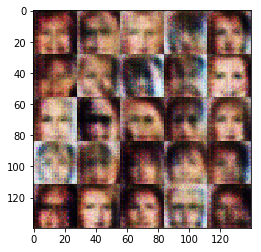

Epoch 0/1... Discriminator Loss: 1.3674... Generator Loss: 0.7671
Epoch 0/1... Discriminator Loss: 1.3921... Generator Loss: 0.8040
Epoch 0/1... Discriminator Loss: 1.3683... Generator Loss: 0.8266
Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.7935
Epoch 0/1... Discriminator Loss: 1.3541... Generator Loss: 0.7721
Epoch 0/1... Discriminator Loss: 1.3698... Generator Loss: 0.7533
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.8140
Epoch 0/1... Discriminator Loss: 1.3776... Generator Loss: 0.8196
Epoch 0/1... Discriminator Loss: 1.3759... Generator Loss: 0.8064


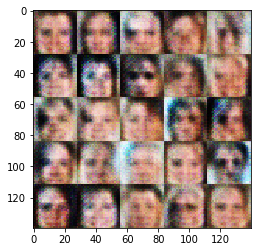

Epoch 0/1... Discriminator Loss: 1.3795... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.8223
Epoch 0/1... Discriminator Loss: 1.3886... Generator Loss: 0.8062
Epoch 0/1... Discriminator Loss: 1.3739... Generator Loss: 0.8157
Epoch 0/1... Discriminator Loss: 1.3856... Generator Loss: 0.7578
Epoch 0/1... Discriminator Loss: 1.3720... Generator Loss: 0.7868
Epoch 0/1... Discriminator Loss: 1.3824... Generator Loss: 0.7470
Epoch 0/1... Discriminator Loss: 1.3699... Generator Loss: 0.8099
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.7682
Epoch 0/1... Discriminator Loss: 1.3819... Generator Loss: 0.8016


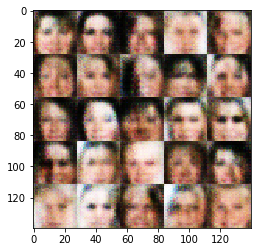

Epoch 0/1... Discriminator Loss: 1.3838... Generator Loss: 0.7648
Epoch 0/1... Discriminator Loss: 1.3770... Generator Loss: 0.8169
Epoch 0/1... Discriminator Loss: 1.3825... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.8151
Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.7611
Epoch 0/1... Discriminator Loss: 1.3873... Generator Loss: 0.8031
Epoch 0/1... Discriminator Loss: 1.3686... Generator Loss: 0.7784
Epoch 0/1... Discriminator Loss: 1.4005... Generator Loss: 0.6787
Epoch 0/1... Discriminator Loss: 1.3755... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.8068


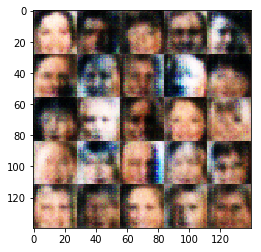

Epoch 0/1... Discriminator Loss: 1.3805... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 1.3716... Generator Loss: 0.8031
Epoch 0/1... Discriminator Loss: 1.3772... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.4039... Generator Loss: 0.6986
Epoch 0/1... Discriminator Loss: 1.3801... Generator Loss: 0.8159
Epoch 0/1... Discriminator Loss: 1.3961... Generator Loss: 0.7389
Epoch 0/1... Discriminator Loss: 1.3941... Generator Loss: 0.8091
Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.8172
Epoch 0/1... Discriminator Loss: 1.3837... Generator Loss: 0.7788
Epoch 0/1... Discriminator Loss: 1.3694... Generator Loss: 0.8031


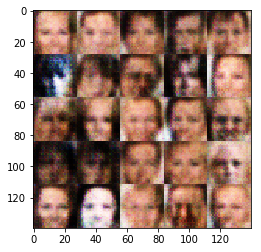

Epoch 0/1... Discriminator Loss: 1.3886... Generator Loss: 0.8275
Epoch 0/1... Discriminator Loss: 1.3810... Generator Loss: 0.8466
Epoch 0/1... Discriminator Loss: 1.3857... Generator Loss: 0.7506
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.8069
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.8267
Epoch 0/1... Discriminator Loss: 1.3861... Generator Loss: 0.7670
Epoch 0/1... Discriminator Loss: 1.4036... Generator Loss: 0.7576
Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.8033
Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.7726
Epoch 0/1... Discriminator Loss: 1.3547... Generator Loss: 0.8095


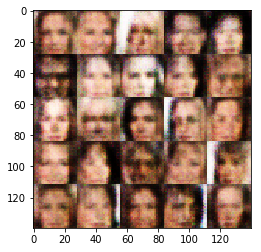

Epoch 0/1... Discriminator Loss: 1.3627... Generator Loss: 0.8012
Epoch 0/1... Discriminator Loss: 1.3619... Generator Loss: 0.7818
Epoch 0/1... Discriminator Loss: 1.3628... Generator Loss: 0.8014
Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.8328
Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 0.7347
Epoch 0/1... Discriminator Loss: 1.3740... Generator Loss: 0.7786
Epoch 0/1... Discriminator Loss: 1.3766... Generator Loss: 0.8226
Epoch 0/1... Discriminator Loss: 1.3808... Generator Loss: 0.7845
Epoch 0/1... Discriminator Loss: 1.3817... Generator Loss: 0.8030
Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.8464


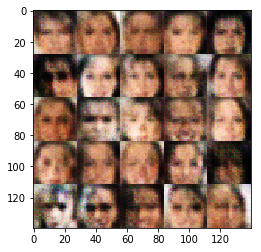

Epoch 0/1... Discriminator Loss: 1.3824... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.3770... Generator Loss: 0.8013
Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.8052
Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 0.8027
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 0.7491
Epoch 0/1... Discriminator Loss: 1.3849... Generator Loss: 0.8419
Epoch 0/1... Discriminator Loss: 1.3911... Generator Loss: 0.7961
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 0.8093
Epoch 0/1... Discriminator Loss: 1.3660... Generator Loss: 0.7898
Epoch 0/1... Discriminator Loss: 1.3731... Generator Loss: 0.8292


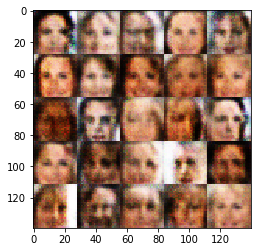

Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.8344
Epoch 0/1... Discriminator Loss: 1.3782... Generator Loss: 0.8041
Epoch 0/1... Discriminator Loss: 1.3738... Generator Loss: 0.7804
Epoch 0/1... Discriminator Loss: 1.3839... Generator Loss: 0.7902
Epoch 0/1... Discriminator Loss: 1.3820... Generator Loss: 0.7831
Epoch 0/1... Discriminator Loss: 1.3751... Generator Loss: 0.8153
Epoch 0/1... Discriminator Loss: 1.3695... Generator Loss: 0.8057
Epoch 0/1... Discriminator Loss: 1.3680... Generator Loss: 0.7611
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.8115
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.7616


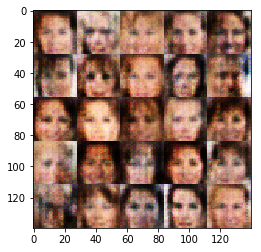

Epoch 0/1... Discriminator Loss: 1.3800... Generator Loss: 0.7549
Epoch 0/1... Discriminator Loss: 1.3762... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 1.3741... Generator Loss: 0.7959
Epoch 0/1... Discriminator Loss: 1.3694... Generator Loss: 0.8111
Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.7853
Epoch 0/1... Discriminator Loss: 1.3739... Generator Loss: 0.7886
Epoch 0/1... Discriminator Loss: 1.3821... Generator Loss: 0.8092
Epoch 0/1... Discriminator Loss: 1.3876... Generator Loss: 0.7604


In [57]:
batch_size = 128
z_dim = 512
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.